In [1]:
import pandas as pd
import numpy as np 

import librosa 

import torch

import matplotlib.pyplot as plt

from IPython.display import Audio

In [ ]:
class Config:

    duration   = 5
    fs         = 32000
    datafolder = 'data'            # modify for appropriate path!
    nsamples   = fs * duration

    padmode    = "circular"
    ufoldoverlap = nsamples//2

    isRGB       = True

    nfft        = 1024
    hoplen      = 512
    nmels       = 128
    fmin        = 50
    fmax        = 14000

config = Config()

In [3]:
def load_data(config):
    taxonomy_df = pd.read_csv(f'{config.datafolder}/taxonomy.csv')
    species_class_map  = dict(zip(taxonomy_df['primary_label'], taxonomy_df['class_name']))
    train_df = pd.read_csv(f'{config.datafolder}/train.csv')

    label_list = sorted(train_df['primary_label'].unique())
    label_id_list = list(range(len(label_list)))
    label2id = dict(zip(label_list, label_id_list))


    df = train_df[['primary_label', 'secondary_labels','rating', 'filename', "author","collection"]].copy()
    df['target'] = df.primary_label.map(label2id)
    df['filepath'] = config.datafolder + '/train_audio/' + df.filename
    df['samplename'] = df.filename.map(lambda x: x.split('/')[0] + '-' + x.split('/')[-1].split('.')[0])
    df['class'] = df.primary_label.map(lambda x: species_class_map.get(x, 'Unknown'))

    print(f'Total samples: There are {len(df)} available')
    print(f'Samples by class:')
    print(df['class'].value_counts())

    return df

def separate_families(df):
    """Separates the different animal families 
    
    Args:
        (dict): with {birds, amph, mamm, insc} families

    """
    
    return  {
    "birds" : df[df['class'] == "Aves"],
    "amph"  : df[df['class'] == "Amphibia"],
    "mamm"  : df[df['class'] == "Mammalia"],
    "insc"  : df[df['class'] == "Insecta"]
    }

def audio_unfolding(audio,config):
    return torch.tensor(audio).unfold(
        dimension=-1,size=config.nsamples,step=config.nsamples//2)

def load_audio(row,config):
    return librosa.load(row.filepath, sr=config.fs)[0]

def get_audio_segments(row,config):
    audio = load_audio(row,config)
    return audio_unfolding(audio,config)

In [4]:
import torchaudio

class MelSpectrogramTransform(object):
    """ Computes the Mel Spectogram of an audio sample

    Args:
        config (object): Configuration parameters for the mel spectogram transform

    """
    def __init__(self,config):

        self.to_melspectogram = torchaudio.transforms.MelSpectrogram(
                sample_rate=config.fs,n_fft=config.nfft,hop_length=config.hoplen,
                f_max=config.fmax,f_min=config.fmin,n_mels=config.nmels)
        
        self.etol = 1E-8

    def __call__(self, audiosample):
    
        if torch.isnan(audiosample).any():
            meanvalue = torch.nanmean(audiosample)
            audiosample = torch.nan_to_num(audiosample, nan=meanvalue)

        output = self.to_melspectogram(audiosample)
        # output = 10*torch.log10(output) - 10*torch.log10(output.max())
        output = librosa.power_to_db(output, ref=np.max)
        output = (output - output.min()) / (output.max() - output.min() + self.etol)

        return torch.tensor(output)
    

audio2melspecdBnorm = MelSpectrogramTransform(config)

def show_melspectogram(audiosample=None,SmeldB=None):
    """ Show Mel-Spectogram"""
    if SmeldB is None:
        if audiosample is None:
            raise Exception("[audiosample] is required when no [SmeldB] is provided")
        melspecdB = audio2melspecdBnorm(audiosample)
    else:
        melspecdB = SmeldB
    plt.imshow(
        melspecdB,
        aspect='auto',origin='lower', cmap='viridis'
    )
    plt.colorbar()
    plt.show()


In [5]:
df = load_data(config)

Total samples: There are 28564 available
Samples by class:
class
Aves        27648
Amphibia      583
Mammalia      178
Insecta       155
Name: count, dtype: int64


In [77]:
class AudioToImages(object):

    def __init__(self):
        self.config = Config()
        self.audio_to_image = MelSpectrogramTransform(config)

    def __call__(self,row,save=False):
        audiosample = torchaudio.load(row.filepath)[0]
        
        nsamples = audiosample.shape[-1]
        rsamples = nsamples%config.nsamples 

        if config.padmode == "custom":
            raise "Not implement"
        else:
            audiosample = torch.nn.functional.pad(
                            audiosample,
                            (0,config.nsamples-rsamples),
                            mode=config.padmode)

        audiosegments = audiosample.unfold(
                            dimension=-1,size=config.nsamples,step=config.ufoldoverlap
                        )

        melspecdBnorm = audio2melspecdBnorm(audiosegments)

        if config.isRGB:
            melspecdBnorm = melspecdBnorm[:,].unsqueeze_(2).repeat(1,1,3,1,1)

        if save:
            'save data'
        return melspecdBnorm,audiosample
    
audio2Imges = AudioToImages()

def show_peak_melspectrograms(row):
    images,audiosample = audio2Imges(row)
    nsegments = images.shape[1]
    plt.figure(figsize=(8*2,6*2))
    nseg2show = min(nsegments,4)
    for n in range(nseg2show):
        segmentid = np.random.randint(nsegments)
        plt.subplot(2,2,n+1)
        plt.imshow(
            images[0,segmentid,1,:,:],
            aspect='auto', origin='lower', cmap='viridis'
        )
        plt.colorbar()
    plt.show()
    return images,audiosample


primary_label                                     pirfly1
secondary_labels        ['yebela1', 'recwoo1', 'yectyr1']
rating                                                4.5
filename                             pirfly1/XC410601.ogg
author                                       Kent Livezey
collection                                             XC
target                                                134
filepath            data/train_audio/pirfly1/XC410601.ogg
samplename                               pirfly1-XC410601
class                                                Aves
Name: 14633, dtype: object


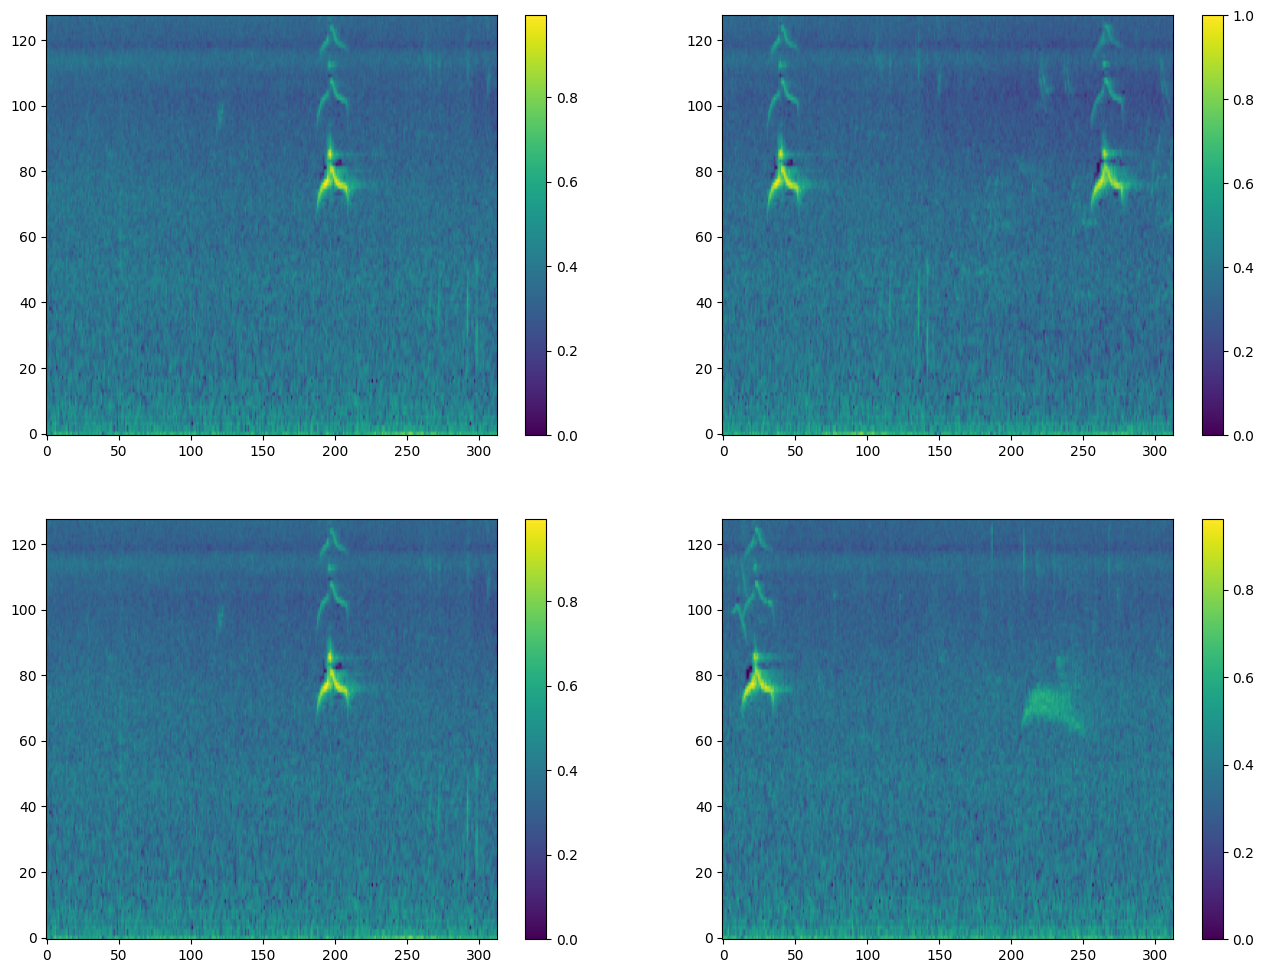

In [195]:
animals = separate_families(df)
family = animals["birds"]

sampleid = np.random.randint(len(family))
audiosegments = get_audio_segments(family.iloc[sampleid],config)
melsegements = audio2melspecdBnorm(audiosegments)

row = family.iloc[sampleid]
images,audiosample = audio2Imges(row)

print(row)

images, audiosample = show_peak_melspectrograms(row)
Audio(audiosample,rate=config.fs)

In [12]:
def id_useful_samples(row):
    if row["author"] == "Fabio A. Sarria-S":
        startsample = 0
        endsample   = 31000

    return startsample,endsample 

In [13]:
authors = np.unique(df[df.collection == 'CSA']["author"])
print(authors)

['Alejandro Mendoza | Mónica Izquierdo' 'Alexandra Buitrago-Cardona'
 'Alexandra Butrago-Cardona' 'Ana María Ospina-Larrea'
 'Ana María Ospina-Larrea | Daniela Murillo' 'Angela M. Mendoza-Henao'
 'Diego A Gómez-Morales' 'Diego A. Gomez-Morales' 'Eliana Barona- Cortés'
 'Eliana Barona-Cortés' 'Eliana Barona-Cortés | Daniela García-Cobos'
 'Fabio A. Sarria-S' 'Fernando Montealegre-Z' 'Gustavo Bravo Mora'
 'J. Sebastian Giraldo-Bernal' 'Johann Stephens Cardenas-Bautista'
 'Mateo Hernandez' 'Mauricio Álvarez-Rebolledo' 'Orlando Acevedo-Charry'
 'Paula Caycedo-Rosales' 'Paula Caycedo-Rosales | Juan-Pablo López']


In [14]:
authordata = {
    author : df[df["author"] == author] 
    for author in authors
}

for key,value in authordata.items():
    print(f'{key}:\t\t\t{len(value)}')

Alejandro Mendoza | Mónica Izquierdo:			1
Alexandra Buitrago-Cardona:			5
Alexandra Butrago-Cardona:			2
Ana María Ospina-Larrea:			4
Ana María Ospina-Larrea | Daniela Murillo:			2
Angela M. Mendoza-Henao:			19
Diego A Gómez-Morales:			5
Diego A. Gomez-Morales:			32
Eliana Barona- Cortés:			4
Eliana Barona-Cortés:			5
Eliana Barona-Cortés | Daniela García-Cobos:			1
Fabio A. Sarria-S:			26
Fernando Montealegre-Z:			24
Gustavo Bravo Mora:			1
J. Sebastian Giraldo-Bernal:			3
Johann Stephens Cardenas-Bautista:			1
Mateo Hernandez:			2
Mauricio Álvarez-Rebolledo:			42
Orlando Acevedo-Charry:			17
Paula Caycedo-Rosales:			1
Paula Caycedo-Rosales | Juan-Pablo López:			1


In [185]:
def plot_segmentation(audiosample,maskspeech,fs=1):
    fig = plt.figure(figsize=(24, 3))

    t = np.arange(audiosample.shape[-1])

    plt.plot(t/fs, 10 * torch.log10(torch.abs(audiosample.squeeze())+1e-8), 'b')

    t = np.arange(maskspeech.shape[-1])

    plt.plot(t/fs, 10*torch.log10(maskspeech.squeeze() + 1e-8), '-r',lw=2)       
    plt.show()

In [ ]:
class SileroVADRemover(object):

    def __init__(self,config):
        self.target_fs = 16000          # silero works @ 8khz/16khz
        self.orig_fs = config.fs
        self.rsratio = vad.orig_fs//vad.target_fs

        self.maxmergingtime_s = 1
        self.maxdistance = self.maxmergingtime_s * config.fs

        # fast resampler - similar config as librosa : from torchaudio docs
        self.resampler = torchaudio.transforms.Resample(
            orig_freq=config.fs,
            new_freq=self.target_fs,
            lowpass_filter_width=16,
            rolloff=0.85,
            resampling_method="sinc_interp_kaiser",
            beta=8.555504641634386,
        )

        torch.set_num_threads(1)
        # it could be possible to fine tune the threshold - discussion about it for soundscapes in forum
        #   from post, people argue that for soundscapes, removing audio should not be done
        self.model, (self.get_speech_timestamps, _, _, _, _) = torch.hub.load(
            repo_or_dir='snakers4/silero-vad', model='silero_vad')

    def __call__(self,row):
        # torchaudio.load and librosa.load give different results... ???
        audiosample = torch.tensor(librosa.load(row.filepath,sr=self.orig_fs)[0])
        rsaudiosample = self.resampler(audiosample)     
        speech_timestamps = self.get_speech_timestamps(rsaudiosample, self.model)

        maskspeech = torch.ones(size=(audiosample.numel(),))
        prev = -np.inf

        for st in speech_timestamps:
            if st['start'] - prev < self.maxdistance:
                st['start'] = prev
            maskspeech[self.rsratio*st['start']:self.rsratio*st['end']] = 0
            prev = st['end']

        # current solution remove detected blocks
        newsample =  audiosample[maskspeech == 1]

        return newsample, audiosample, maskspeech
    
vad = SileroVADRemover(config)


Using cache found in C:\Users\coutinominguezma/.cache\torch\hub\snakers4_silero-vad_master


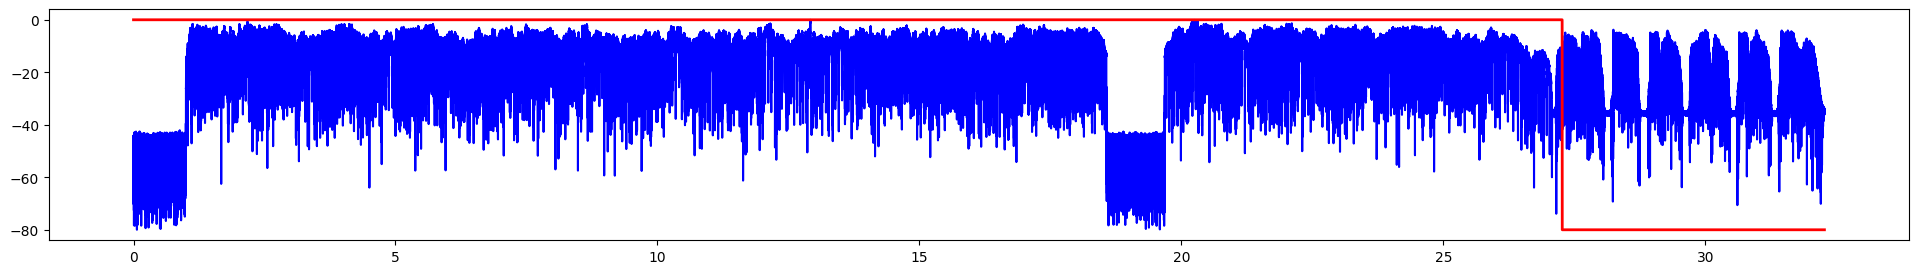

Original Audio


New Audio


In [191]:
for author in authors[6:7]:
    data = authordata[author]
    rowid = np.random.randint(len(data))
    newsample, audiosample, mask = vad(data.iloc[rowid])
    plot_segmentation(audiosample,mask,config.fs)
    print('Original Audio')
    display(Audio(audiosample,rate=config.fs))
    print('New Audio')
    display(Audio(newsample,rate=config.fs))
